In [ ]:
import os.path
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem   import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import io

Upload file

In [ ]:
from google.colab import files
 
dataset = files.upload()

Saving Fake_News_Dataset.csv to Fake_News_Dataset (1).csv


In [ ]:
df = pd.read_csv(io.BytesIO(dataset['Fake_News_Dataset.csv']))
print(df.shape)
df.head(10)

(72134, 4)


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1


Text preprocessing procedure

1.   Remove punctuation and digits
2.   Tokenize
3.   Lemmatize
4.   Remove stopwords



In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def preprocess_text(text):
    text = ''.join([c for c in text if c not in string.punctuation and c not in string.digits])
    tokens = word_tokenize(text, 'english')
    lemmatiser = WordNetLemmatizer()
    lemmatized = [lemmatiser.lemmatize(word) for word in tokens]
    sw = stopwords.words('english')
    stopped = [word for word in lemmatized if word.lower() not in sw]
    return stopped

preprocess_text(df.loc[0, 'title'])

['LAW',
 'ENFORCEMENT',
 'HIGH',
 'ALERT',
 'Following',
 'Threats',
 'Cops',
 'Whites',
 'BlackLivesMatter',
 'FYF',
 'Terrorists',
 'VIDEO']

Split into train/test keeping 20% of the data for testing

In [ ]:
from sklearn.model_selection import train_test_split

X = df['title']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape[0], X_test.shape[0]

(57707, 14427)

Does the target variable balanced?

In [ ]:
y_train.value_counts(normalize=True)

1    0.515847
0    0.484153
Name: label, dtype: float64

Represent the titles using bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
X_train = X_train.fillna('')
bow_transformer = CountVectorizer(analyzer=preprocess_text).fit(X_train)
text_bow_train = bow_transformer.transform(X_train)

Cross validate a Random Forest classifier on the bag of words representation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

model = RandomForestClassifier(n_estimators=100)

scores = cross_validate(model, text_bow_train, y_train, scoring=['f1', 'accuracy'], cv=None, n_jobs=-1)
scores

{'fit_time': array([323.06475639, 321.36848831, 315.22505832, 314.12265372,
        200.99005747]),
 'score_time': array([1.76979756, 1.79160833, 1.91787219, 1.86520481, 1.49667406]),
 'test_accuracy': array([0.93735921, 0.93848553, 0.93839355, 0.94012651, 0.93804696]),
 'test_f1': array([0.94017377, 0.94150601, 0.94128334, 0.94277433, 0.94083575])}


# scoring=['f1', 'accuracy']
>**f1** - гармоническое среднее точности и запоминания, где оценка Формулы-1 достигает своего лучшего значения при 1 и худшего балла при 0.

>**accuracy** - оценка классификации точности.

# n_jobs=-1
> **n_jobs** - этот параметр используется для указания количества параллельных процессов или потоков. -1 означает, что используются все процессоры (для отладки можно использовать 1, что означает параллелизм joblib не используется вообще.
# cv=5
> **cv** - пределяет стратегию разделения cross validation (Можно использовать None - для 5-кратной перекрестной проверки по умолчанию)
# text_bow_train

















Now retrain the model on the whole training set

In [ ]:
model.fit(text_bow_train, y_train)

RandomForestClassifier()

And see the metrics on the test set

In [ ]:
from sklearn.metrics import classification_report

X_test = X_test.fillna('')
text_bow_test = bow_transformer.transform(X_test)

y_pred = model.predict(text_bow_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      7089
           1       0.93      0.96      0.94      7338

    accuracy                           0.94     14427
   macro avg       0.94      0.94      0.94     14427
weighted avg       0.94      0.94      0.94     14427



Achieved 94% accuracy on the test set

(-0.5, 399.5, 199.5, -0.5)

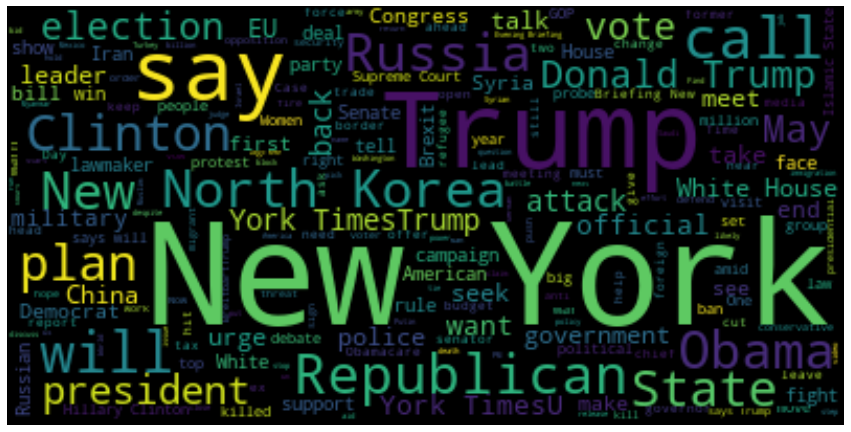

In [ ]:
from wordcloud import WordCloud

wc = WordCloud().generate(df.groupby('label')['title'].sum()[0])
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")